In [1]:
import vaex
import vaex.ml

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [4]:
# /Users/caselyhayford/Desktop/optimization_presentation_playground/vaex_ml.ipynb
df = vaex.open('/Users/caselyhayford/Desktop//yellow_taxi_2015_f32s.hdf5')

In [5]:
df.head()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2014-12-16 02:26:00.000000000,2014-12-16 02:28:00.000000000,1,CSH,1.09,-73.9867,40.7564,1,nan,-73.9965,40.7429,5,0.5,0.5,0,0,6
1,VTS,2014-12-15 18:23:00.000000000,2014-12-15 18:58:00.000000000,2,,6.28,-74.0042,40.7212,1,nan,-73.97,nan,nan,nan,nan,nan,nan,nan
2,VTS,2015-01-15 19:05:39.000000000,2015-01-15 19:23:42.000000000,1,1,1.59,-73.9939,40.7501,1,0,-73.9748,40.7506,12,1,0.5,3.25,0,17.05
3,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:53:28.000000000,1,1,3.3,-74.0016,40.7242,1,0,-73.9944,40.7591,14.5,0.5,0.5,2,0,17.8
4,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:43:41.000000000,1,2,1.8,-73.9633,40.8028,1,0,-73.9518,40.8244,9.5,0.5,0.5,0,0,10.8
5,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:35:31.000000000,1,2,0.5,-74.0091,40.7138,1,0,-74.0043,40.72,3.5,0.5,0.5,0,0,4.8
6,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:52:58.000000000,1,2,3,-73.9712,40.7624,1,0,-74.0042,40.7427,15,0.5,0.5,0,0,16.3
7,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:53:52.000000000,1,1,9,-73.8744,40.774,1,0,-73.987,40.7582,27,0.5,0.5,6.7,5.33,40.33
8,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:58:31.000000000,1,2,2.2,-73.9833,40.726,1,0,-73.9925,40.7496,14,0.5,0.5,0,0,15.3
9,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:42:20.000000000,3,1,0.8,-74.0027,40.7341,1,0,-73.995,40.7263,7,0.5,0.5,1.66,0,9.96


/Users/caselyhayford/.pyenv/versions/3.10.6/envs/playground/lib/python3.10/site-packages/vaex/viz/mpl.py:315: UserWarning: `plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.
  warnings.warn('`plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.')


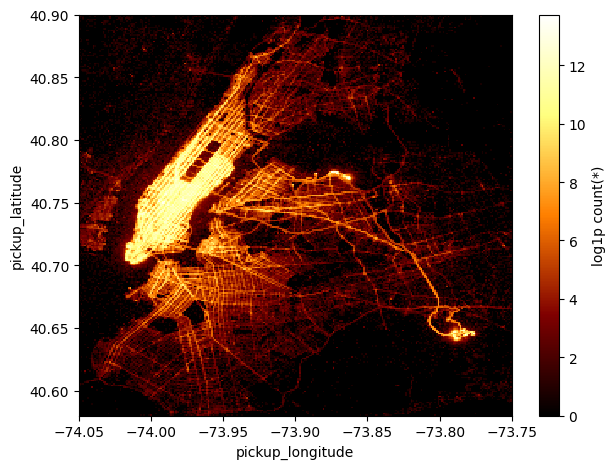

In [6]:

df.plot(df.pickup_longitude, df.pickup_latitude, f="log1p", limits=[[-74.05, -73.75], [40.58, 40.90]], show=True);

In [7]:
df_train, df_test = df.shuffle().ml.train_test_split(test_size=0.2)

/Users/caselyhayford/.pyenv/versions/3.10.6/envs/playground/lib/python3.10/site-packages/vaex/ml/__init__.py:28: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


In [8]:
# # Train / test split (by date, data is ordered by year)
# df_train = df[:1_026_944_937]
# df_test = df[1_026_944_937:]
# df_test_prod = df_test.copy() # For an in-production scenario example

# print(f'Number of samples in the training set: {len(df_train):,}')
# print(f'Number of samples in the test set:       {len(df_test):,}')

# # Check if the lengths of the datasets match
# assert len(df) == len(df_test) + len(df_train)

In [9]:
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

In [10]:
# Speed (miles per hour) - To be used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

In [11]:
# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Select taxi trips have travelled maximum 7 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 7)]

# Filter taxi trips that have durations longer than 25 minutes or that lasted less than 3 minutes
df_train = df_train[(df_train.trip_duration_min > 3) & (df_train.trip_duration_min < 25)]

# Filter out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

# If there are unknown (N/A) pick-up or drop-off locations, choose a representative value. 
df_train['dropoff_latitude'] = df_train.dropoff_latitude.fillna(value=40.76)
df_train['pickup_latitude'] = df_train.pickup_latitude.fillna(value=40.76)

df_train['dropoff_longitude'] = df_train.dropoff_longitude.fillna(value=-73.99)
df_train['pickup_longitude'] = df_train.pickup_longitude.fillna(value=-73.99)

In [12]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_month'] = df_train.pickup_datetime.dt.month - 1 # so it starts from 0
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [13]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Create the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [14]:
# Direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Create the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

In [15]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pickup = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2, prefix='PCA_pickup_')
df_train = pca_pickup.fit_transform(df_train)

# dropoff transformations
pca_dropoff = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2, prefix='PCA_dropoff_')
df_train = pca_dropoff.fit_transform(df_train)

/Users/caselyhayford/.pyenv/versions/3.10.6/envs/playground/lib/python3.10/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)
/Users/caselyhayford/.pyenv/versions/3.10.6/envs/playground/lib/python3.10/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: invalid value encountered in divide
  result_data = op['op'](a_data, b_data)


/Users/caselyhayford/.pyenv/versions/3.10.6/envs/playground/lib/python3.10/site-packages/vaex/viz/mpl.py:315: UserWarning: `plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.
  warnings.warn('`plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.')


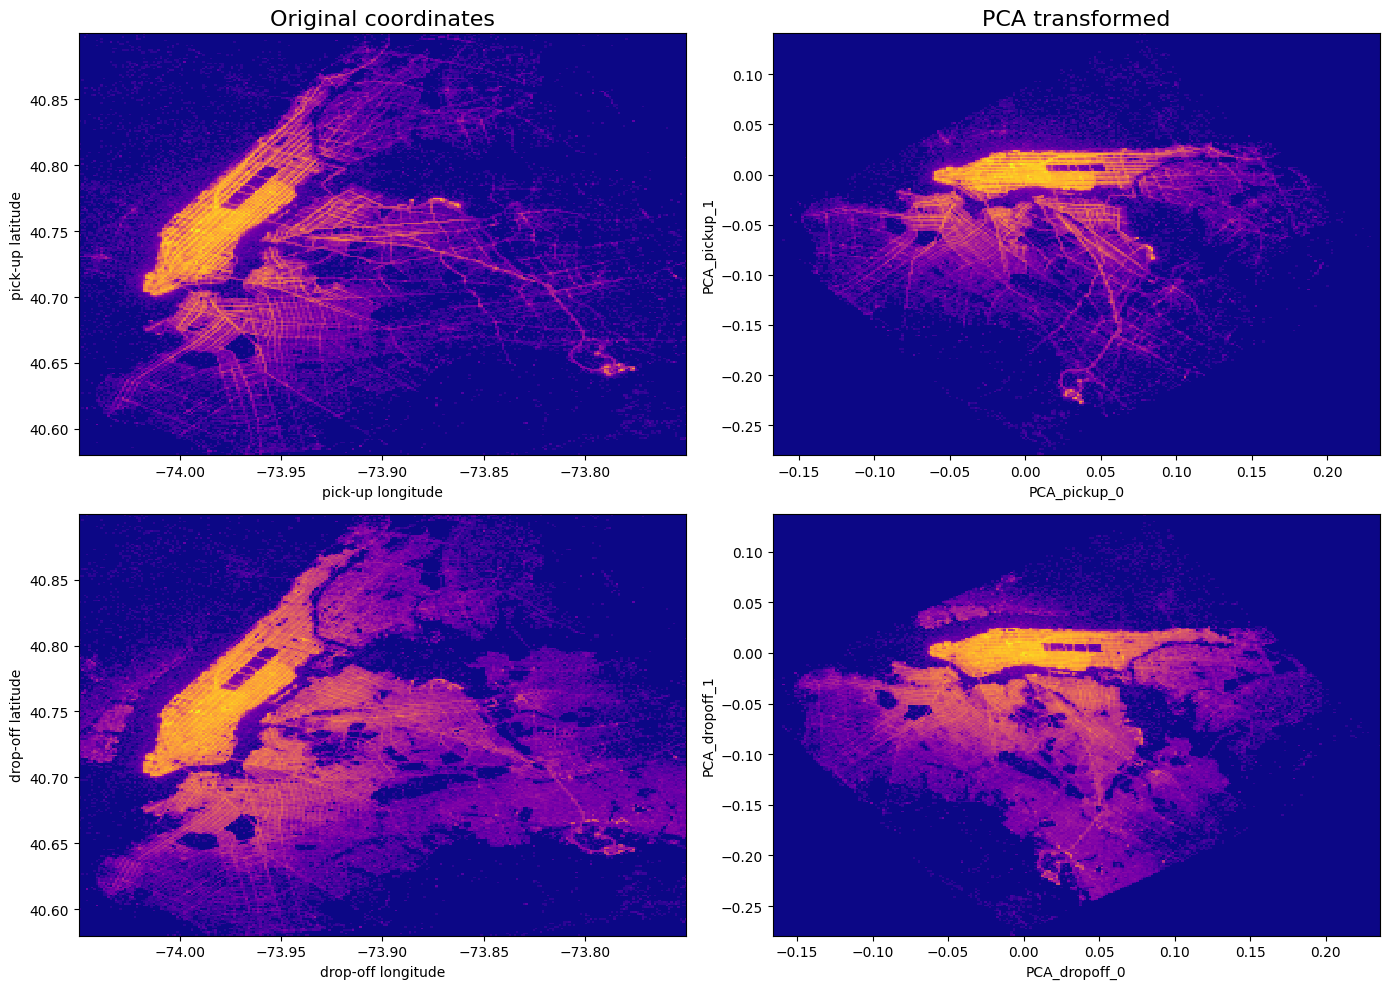

In [16]:
# Visualise the PCA results to make sure they makes sense
plt.figure(figsize=(14, 10))

plt.subplot(221)
plt.title('Original coordinates', fontsize=16)
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False, 
              xlabel='pick-up longitude', ylabel='pick-up latitude')

plt.subplot(222)
plt.title('PCA transformed', fontsize=16)
df_train.plot(df_train.PCA_pickup_0, df_train.PCA_pickup_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_pickup_0', ylabel='PCA_pickup_1')
              

plt.subplot(223)
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='drop-off longitude', ylabel='drop-off latitude')

plt.subplot(224)
df_train.plot(df_train.PCA_dropoff_0, df_train.PCA_dropoff_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_dropoff_0', ylabel='PCA_dropoff_1')

plt.tight_layout()
plt.show()